## Building a classifier model for the Multivariate Time Series data using LSTM in Keras


This is a three-class classification problem for the given multivariate time series data. The "goal" column has three values 0 (no event), 1 (event of type 1), and 2 (event of type 2). Although we can treat events 1 and 2 as one "positive" class and 0 as the "negative" class, we will build a 3-class classifier and create a confusion matrix.  

We use LSTM, which is a variation of RNN, for building our network.

#### About the dataset:
There are 17 columns in total, of which the first two columns are the IDs for each timeseries (to mark the beginning and end of each timeseries), and are therefore discarded. The next 14 columns are the variables listed in time in equal intervals, and the last column is the "goal" column. There are 89 samples in each time series. For example, rows 2 to 90 represent one time series, rows 91 to 178 represent the next time series, and so on.


#### Lets start by importing the necessary modules and loading the raw dataset:

In [1]:
import numpy as np
from pandas import read_excel, DataFrame, concat
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler

# Loading the raw dataset (ignore the first 2 columns A & B)
dataset = read_excel("challenge_dataset.xlsx", usecols="C:Q")

values = dataset.values

print(dataset.head(3)) # Lets print the first 3 rows of the dataset to take a peek at what we have

Nc = values.shape[1] # number of columns

values = values.astype('float32') # ensuring all the data is float

# normalizing features (columns 1 to 14) NOTE: column 15 = goal (three classes: 0, 1, 2)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values[:,0:Nc])

print()
print("values.shape =", values.shape)
print("scaled.shape =", scaled.shape)


     bx    by    bz    bl    bm    bn  bmag      vx      vy     vz    vmag  \
0  0.52  3.99 -2.53  0.12 -4.74 -0.33  4.75 -212.49  126.52  94.29  264.67   
1 -0.46  2.83 -0.37  1.47 -2.49 -0.08  2.89 -205.30  121.80  91.70  255.72   
2  0.63  3.69 -2.23  0.10 -4.36 -0.12  4.36 -208.85  119.43  89.61  256.73   

     np    tpar    tper  goal  
0  5.51  141.67  157.74     2  
1  6.51  139.22  154.13     2  
2  6.15  144.39  151.92     2  

values.shape = (18245, 15)
scaled.shape = (18245, 15)


Note that we normalized all the features so that they range between 0 and 1.

Now we need to frame the raw dataset into a supervised learning problem.
We set timestep equal to 1 (t_prev = 1), which means that we only look at the data in the previous row to train and predict the class.

In [2]:
##############################################################
# framing the problem as supervised learning

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame the time series as a supervised learning dataset.
    
    Arguments:
        data:    Sequence of observations as a list or NumPy array.
        n_in:    Number of lag observations as input (X).
        n_out:   Number of observations as output (y).
        dropnan: Boolean, whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """

    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # future sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

t_prev = 1 # timestep
t_next = 1
reframed = series_to_supervised(scaled, t_prev, t_next)
print("reframed.shape before drop =", reframed.shape)
# dropping the columns that we don't want to predict
reframed.drop(reframed.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27,28]], axis=1, inplace=True)
print("reframed.shape after  drop =", reframed.shape)


reframed.shape before drop = (18244, 30)
reframed.shape after  drop = (18244, 16)


Now we will split the data into train/dev and test sets.

We use 60% of the data for training, of which 20% is used for evaluation purposes (to make sure we are not overfitting). The rest of the data (40%) will be set aside to test the accuracy of the model.

Note: we could also use 50% or 40% of the data for training/development purposes and use the remaining 50% or 60% of the data for test. The outcome would be very similar.

In [3]:
#############################################################################
# splitting the data into train and test sets

# taking 60% of the data for train/dev, and the remaining 40% for test
n_train = 89 * int( reframed.values.shape[0]/89 * 0.60) #each time series has 89 entities

# inputs
train_X = np.array(reframed.values[:n_train, :])
test_X  = np.array(reframed.values[n_train:, :])
# outpts (making sure outputs are arrays of integers)
last_column = values.shape[1] - 1 # last column (goal) in the raw dataset
train_Y = np.array(values[t_prev:n_train+t_prev, last_column], dtype=int)
test_Y  = np.array(values[t_prev+n_train:   , last_column], dtype=int)

# Lets convert Y into a "one-hot representation" to make it suitable for the softmax classifier.
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y
train_Y = convert_to_one_hot(train_Y, C = 3)
test_Y  = convert_to_one_hot(test_Y,  C = 3)
# now each row in Y will be a one-hot vector representing each class (0, 1, or 2)

# reshaping the input data to be 3D for Keras [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], t_prev, train_X.shape[1]))
test_X  = test_X.reshape( (test_X.shape[0],  t_prev,  test_X.shape[1]))
print("train_X.shape =", train_X.shape)
print("test_X.shape  =", test_X.shape)
print("train_Y.shape =", train_Y.shape)
print("test_Y.shape  =", test_Y.shape)


train_X.shape = (10858, 1, 16)
test_X.shape  = (7386, 1, 16)
train_Y.shape = (10858, 3)
test_Y.shape  = (7386, 3)


Now we will design the LSTM model in Keras. We use 32 hidden units for the LSTM layer. For optimization, we use Adam algorithm with a learning rate of 0.01, $\beta_1$=0.9, $\beta_2$=0.999, and a decay rate of 0.01. We set the number of epuchs to 4 (higher values result in overfitting).

#### The most important hyperparameters in our model are:
- number of hidden units in LSTM
- learning rate
- timestep (t_prev)
- number of epuchs

The values for the chosen hyperparameters above lead to satisfactory results.

Using TensorFlow backend.


Train on 8686 samples, validate on 2172 samples
Epoch 1/4
 - 1s - loss: 0.7913 - acc: 0.7039 - val_loss: 0.4240 - val_acc: 0.8287
Epoch 2/4
 - 0s - loss: 0.2339 - acc: 0.9553 - val_loss: 0.1571 - val_acc: 0.9899
Epoch 3/4
 - 0s - loss: 0.0794 - acc: 0.9968 - val_loss: 0.0743 - val_acc: 0.9959
Epoch 4/4
 - 0s - loss: 0.0456 - acc: 0.9970 - val_loss: 0.0503 - val_acc: 0.9963


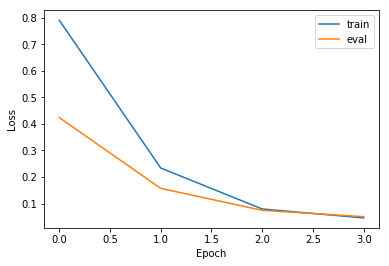

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 6,371
Trainable params: 6,371
Non-trainable params: 0
_________________________________________________________________


In [4]:
#############################################################################
# building the model in Keras

from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation

# designing the network
input_shape = (train_X.shape[1], train_X.shape[2])

model = Sequential()
model.add(LSTM(32, input_shape=input_shape))
model.add(Dense(3))
model.add(Activation('softmax'))

opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
### optimizer='adam'
### loss='categorical_accuracy', 'msle'
### metrics=['accuracy'], ['msle', 'mae']
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# fitting the network
#Trained = model.fit(train_X, train_Y, epochs=5, validation_data=(test_X, test_Y), verbose=2, shuffle=False)
Trained = model.fit(train_X, train_Y, epochs=4, validation_split = 0.2, verbose=2, shuffle=False)

# plotting history
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.plot(Trained.history['loss'],     label='train')
pyplot.plot(Trained.history['val_loss'], label='eval')
pyplot.legend()
pyplot.show()

# summary of the model
model.summary()


The accuracy of the training and development sets, based on the categorical crossentropy loss, is found to be 99.71% and 99.63%, respectively.

We now evaluate the model to test its accuracy and to create a confusion matrix:

In [5]:
#############################################################################
# evaluating the model

from sklearn.metrics import confusion_matrix, classification_report

Test = model.evaluate( test_X, test_Y, verbose=1 )
print()
print("Test Loss: ", Test[0])
print("Accuracy:  ", Test[1])
print()

Predict = model.predict(test_X)
#print("Predict.shape =", Predict.shape)

Y_pred = np.argmax(Predict, axis=1)
Y_true = np.argmax(test_Y,  axis=1)

#for i in range(150,160):
#    print(Y_pred[i], Y_true[i])

print("Confusion Matrix:")
print(confusion_matrix(Y_true, Y_pred))

print("\n Classification Report:")
target_classes = ['No event 0 (-)', 'Event 1 (+)', 'Event 2 (+)']
print(classification_report(Y_true, Y_pred, target_names=target_classes))


7386/7386 [==============================] - 0s 14us/step

Test Loss:  0.047450723017397195
Accuracy:   0.9959382615759546

Confusion Matrix:
[[3363   18    0]
 [   0 1865    4]
 [   0    8 2128]]

 Classification Report:
                precision    recall  f1-score   support

No event 0 (-)       1.00      0.99      1.00      3381
   Event 1 (+)       0.99      1.00      0.99      1869
   Event 2 (+)       1.00      1.00      1.00      2136

   avg / total       1.00      1.00      1.00      7386



In addition to the overal accuracy and the confusion matrix, other important criteria such as precision and recall of our classifier are shown in the table above.